# Collecting Typical Blobs based on pre-detected cells in a cube

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [86]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = min(max_0+margin,im0max)
    min_1 = max(min_1-margin,0)
    max_1 = min(max_1+margin,im1max)
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/abs(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'area':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'eccentricity':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'moments_hu':
            difference = np.abs(np.abs(oriIprops) - np.abs(np.array(nextIprops[i],dtype=np.float)))/np.abs( np.max(np.abs(np.vstack((oriIprops,nextIprops[i]))),axis=0) + 10**(-16)) 
        
        elif distance_type == 'equivalent_diameter':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'orientation':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            similarity.append(np.cos(diff_angle))
            continue
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle) 
        similarity.append( 1 - difference) 
    return similarity

def fun_reconstruct_labeled_image(cell_global_coord,oriImL0, oriImL1, crop_range=None, op_clear_border=True,op_relabel=True):
    """ cell_global_coord = list of coordinate of the global index position of all the pixel in each blob
        oriImL1, oriImL0 = metadata_cache['image_shape][stack]
        crop_range = (min0, max0, min1, max1)
        return: labeled_image, blob_prop_List
    """
    cell_numbers = len(cell_global_coord);
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    
    for tempBlobIndex in range(cell_numbers):
        tempBlobCoor = cell_global_coord[tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if crop_range is not None:
        crop_0_min = crop_range[0]
        crop_0_max = crop_range[1]
        crop_1_min = crop_range[2]
        crop_1_max = crop_range[3]
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if op_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)
        
    if op_relabel:
        im_label_ori = tempLabeledImage
        tempLabeledImage = skimage.measure.label(tempLabeledImage > 0)
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop, im_label_ori
    else:
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop

def fun_blobs_in_polygen(blob_centroid_list, contour_vertice_coor_array, crop_min_list=[0,0]):
    contourPath = matplotlib.path.Path(contour_vertice_coor_array[:,[1,0]] - crop_min_list)
    return contourPath.contains_points(blob_centroid_list)

In [27]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
crop_0_min = 7000
crop_0_max = 13000
crop_1_min = 3000
crop_1_max = 14000
# Inside
# crop_0_min = 4000
# crop_0_max = 6000
# crop_1_min = 2400
# crop_1_max = 4400

# Whole
# crop_0_min = 0
# crop_1_min = 0
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

### Load and crop origninal images

In [17]:
# Set examine section number range and download from S3 if not available
section_begin = 152
section_end = 156
img_filename = {}
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
secList = range(section_begin, section_end +1 )

for tempSec in secList:
    img_filename[tempSec] = DataManager.get_image_filepath(stack=stack, section=tempSec, resol='lossless', version='cropped')
    cell_centroids[tempSec] = load_cell_data('centroid',stack=stack,sec=tempSec)
    cell_numbers[tempSec] = cell_centroids[tempSec].shape[0]
    cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    if os.path.isfile(img_filename[tempSec]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempSec])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            secList.remove(tempSec)
            continue           
            
    

Image file is already available. 
Image file is already available. 
Image file is already available. 
Image file is already available. 
Image file is already available. 


In [28]:
# Load image, change RGB images to grayscale image, rescale the grayscale
option_rescale_grayscale = True
option_inverse_color = False
sec = section_begin + 1

im_cropped = {}
im_rescale = {}
for tempSec in secList:
    im_cropped[tempSec] = img_as_ubyte(rgb2gray(imread(img_filename[tempSec])[crop_0_min:crop_0_max,crop_1_min:crop_1_max]))
    if option_rescale_grayscale:
        im_rescale[tempSec] = fun_rescale_grayscale_image(im_cropped[tempSec],invcol=option_inverse_color)


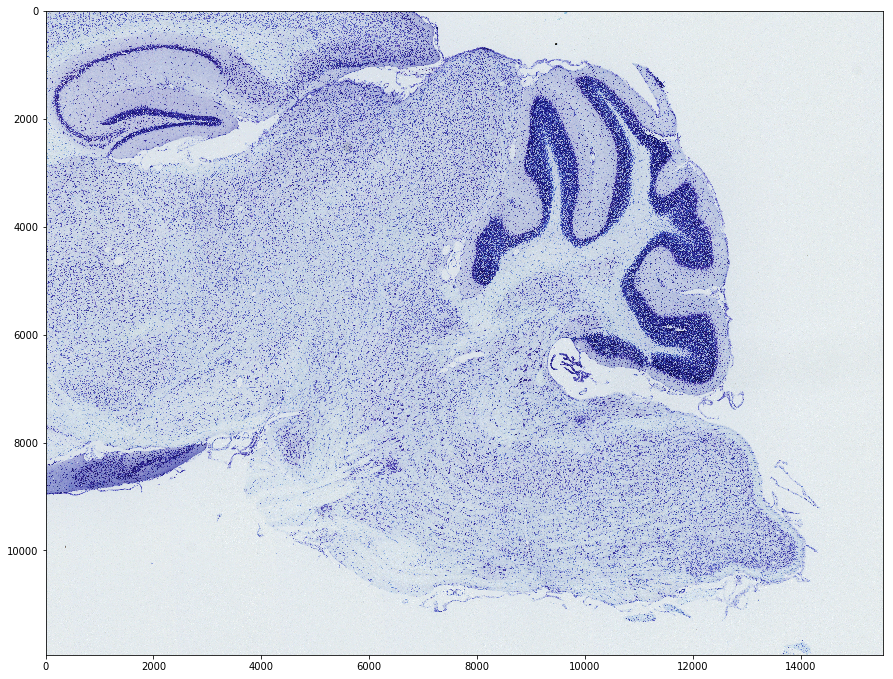

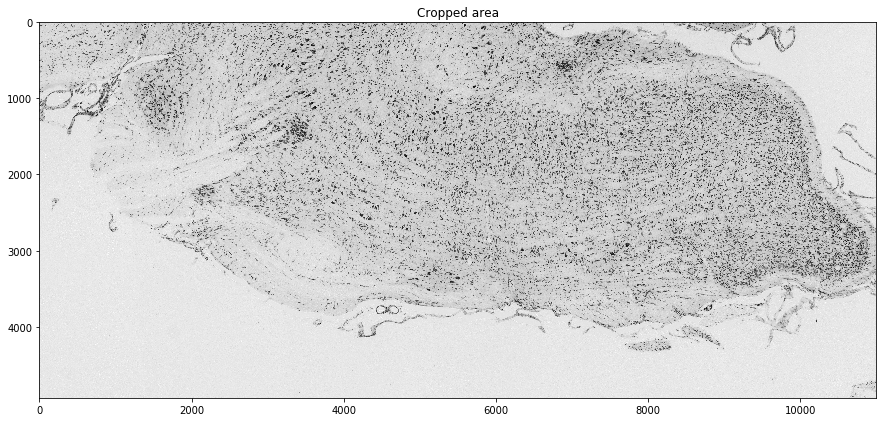

In [30]:
# Show the entire image
plt.figure(figsize=(15,15))
plt.imshow(imread(img_filename[sec]))
# Show the cropped image
plt.figure(figsize=(15,15))
plt.imshow(im_cropped[sec],cmap=plt.cm.gray)
plt.title('Cropped area')
           

### Reconstruct labeled image from detected cell dataset

In [31]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [47]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSec in secList:
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label[tempSec] = temp_im_label
    im_BW[tempSec] = temp_im_label>0
    im_blob_prop[tempSec]  = temp_im_blob_prop

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}

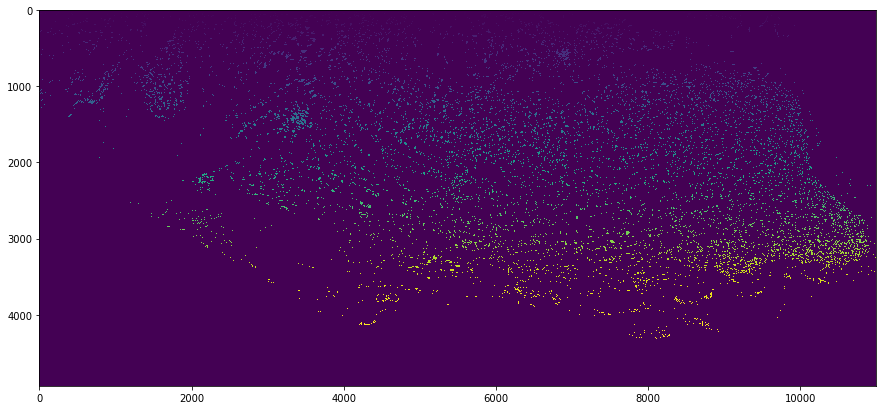

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(im_label[sec])

To do list: 
1. Collect typical blobs. Typical in a sense that they match blobs in the corresponding neighboring region in the next section( based on the aligned image).
    - Read images of given sections in a given list as dictionary. Crop the brain stem area
    - Reconstruct labeled blob image
    - Write a function: input list of bolb centroid, vertice coordinate of the polygon, output the bool vector of existence
    - Check if each blob in section is typical or not. If yes, record the blob index, as well as the matched blob index in the nearby section
    - Visualize the typical blob in 3D (?)
    |
    

    

In [101]:
sec = section_begin + 1
scan_section_range = 1
scan_section = range(sec - scan_section_range, sec + scan_section_range + 1)
scan_section.remove(sec)

In [139]:
blobID = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
prop_for_comparison = ['area', 'orientation', 'eccentricity','equivalent_diameter','moments_hu']
o_scan_size_coeff = 5
o_scan_size = 112
o_fix_scan_size = True

temp_curr_blob_props = im_blob_prop[sec][blobID]

tempB1_idx_loc = temp_curr_blob_props['centroid']
tempB1_orientation = temp_curr_blob_props['orientation']
tempB1_hu = temp_curr_blob_props['moments_hu']
tempB1_size = temp_curr_blob_props['area']
if o_fix_scan_size:
    temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
    temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
else:
    temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
    temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

### Get blob properties in the next section

In [104]:
tempSec = scan_section[0]
if tempSec in secList:
    print('Section %d is in the load image list.'%tempSec)



Section 152 is in the load image list.


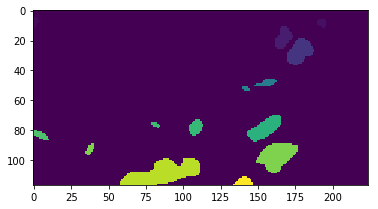

In [149]:
temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0)
temp_num_blob = len(tempBlobInsideIndex)
plt.imshow(temp_im)
if temp_num_blob:
    temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
else:
    print('No blobs found in this section')
    
    
# Get blob properties
temp_next_blob_props = {}
for tempProp in prop:
    temp_prop_value = []
    for blobIndex in range(temp_num_blob):
        temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
    temp_next_blob_props[tempProp] = temp_prop_value
temp_next_blob_props['relative_dict'] = []
for blobIndex in range(temp_num_blob):
    temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

temp_sim = {}

for temp_prop in prop_for_comparison:
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                 temp_next_blob_props[temp_prop],distance_type=temp_prop))
temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

# Blob comparsion

In [144]:
# compare_weight = [6,1,3]
compare_weight = [1 for i in range(len(temp_sim_matrix[0]))]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.7
o_scan_size_coeff = 4

In [145]:
temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)

In [152]:
temp_weighted_sim

array([ 0.49580042,  0.59597822,  0.50542355,  0.22695775,  0.65638388,
        0.37970305,  0.56532199,  0.59996251,  0.30343339,  0.21131196,
        0.34402622,  0.29939196,  0.66482913,  0.59083011])

In [150]:
temp_next_sec_range1 = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='1D')[0]
temp_next_sec_image = fun_crop_images(im_label[tempSec],*temp_next_sec_range1,im1max=im1max,im0max=im0max)

In [160]:
tempBlobInsideIndex

array([ 12,  21,  38,  76, 213, 231, 324, 338, 346, 364, 408, 409, 453, 506])

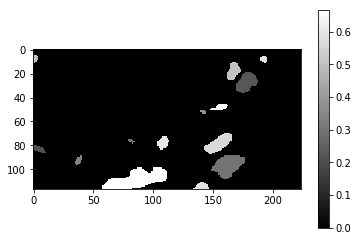

In [164]:
temp_next_sec_image_sim = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D).astype(np.float)
for tempIndex in range(len(temp_weighted_sim)):
#     print(tempIndex)
#     print('Blob %d value replaced to be %f  '%(tempBlobInsideIndex[tempIndex],temp_weighted_sim[tempIndex]))
    temp_matched_pixel = (temp_next_sec_image_sim == (tempBlobInsideIndex[tempIndex]))
#     print('Number of pixel value replaced = %d \n'% np.count_nonzero(temp_matched_pixel))
    temp_next_sec_image_sim[temp_matched_pixel] = temp_weighted_sim[tempIndex]
temp_next_sec_image_sim[np.logical_or(temp_next_sec_image_sim<0,temp_next_sec_image_sim>1)] = 0
# temp_next_sec_image_sim[temp_next_sec_image_sim < o_simil_threshold] = 0
plt.imshow(temp_next_sec_image_sim, cmap=plt.cm.gray);
plt.colorbar();

In [167]:
temp_compare_result = temp_weighted_sim>o_simil_threshold
temp_compare_result = any(temp_compare_result.tolist())
temp_compare_result

False

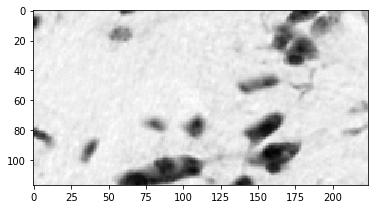

In [169]:
plt.imshow(fun_crop_images(im_rescale[tempSec],*temp_next_sec_range_1D),cmap=plt.cm.gray)

In [173]:
im_blob_prop[sec][blobID]['contour']

KeyError: 'contour'

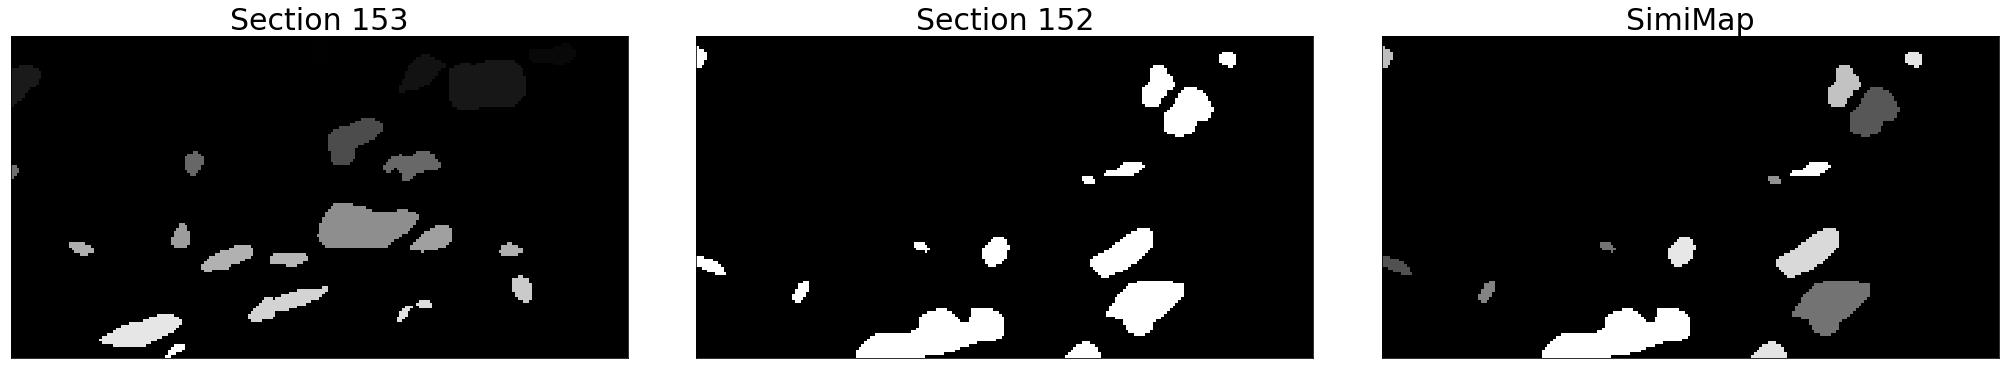

In [171]:
display_images_in_grids([ fun_crop_images(im_label[sec],*temp_next_sec_range_1D).astype(float) , 
                         fun_crop_images(im_BW[tempSec],*temp_next_sec_range_1D).astype(float),
                         temp_next_sec_image_sim],
                        nc=3,titles=['Section %d'%sec, 'Section %d'%tempSec,'SimiMap'], cmap=plt.cm.gray)

# Integrated - blob comparsion

In [482]:
prop = ['centroid','eccentricity','area','equivalent_diameter','orientation','moments_hu','bbox']
compare_props = ['area', 'orientation', 'eccentricity','equivalent_diameter','moments_hu']
# compare_weight = [6,1,3]
compare_weight = [1 for i in range(len(compare_props)+6)]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.8
o_scan_size_coeff = 5
o_record_similar_blob_next_sec = True

In [483]:
n_blobs = map(len, im_blob_prop.values())

In [484]:
im_blob_typical[tempSec] = np.zeros((n_blobs[tempSecIndex],1),dtype=bool)

In [485]:
im_blob_prop[sec][0]

In [486]:
im_blob_typical = {}
im_blob_sim_score = {}
im_blob_sim_crop_im = {}
im_blob_crop_range_1D = {}
# Initialize recording variable: im_blob_typical (initialized to be nontypical) & im_blob_sim_score: highest similarity for each blob in each section
for tempSecIndex in range(n_images):
    tempSec = secIndexList[tempSecIndex]
    im_blob_typical[tempSec] = np.zeros((n_blobs[tempSecIndex],1),dtype=bool)
    im_blob_sim_score[tempSec] = np.zeros((n_blobs[tempSecIndex],1),dtype=float)
    im_blob_sim_crop_im[tempSec] = {}
    im_blob_crop_range_1D[tempSec] = {}
# tempRegion1 = im_blob_prop[sec][blobID]

secIndex = 0
sec = secIndexList[secIndex]
temp_next_secIdx = secIndex + 1;
if temp_next_secIdx < n_images:
    temp_next_sec = secIndexList[temp_next_secIdx]
else:
    sys.stderr('Reach the limit of the stack...')
# blobID = 142
# n_blobs = len(im_blob_prop[sec])
temp_next_blob_centroid = [im_blob_prop[temp_next_sec][tempBIdx]['centroid'] for tempBIdx in range(n_blobs[temp_next_secIdx])]


for blobID in range(n_blobs[secIndex]):
# for blobID in range(10,11):
    # Initialization. 
    
    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = im_blob_prop[sec][blobID][tempProp]

    tempB1_radius = fun_radius_bbox(*temp_curr_blob_props['bbox'])
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']

    temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props['bbox']),im0max=im0max,im1max=im1max,o_form='2D')
    temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props['bbox']),im0max=im0max,im1max=im1max)
    
    
    tempPath = matplotlib.path.Path(temp_next_sec_range)
    tempBlobInside = tempPath.contains_points(temp_next_blob_centroid)
    tempBlobInsideIndex = np.arange(0,n_blobs[temp_next_secIdx], dtype=np.int32)
    tempBlobInsideIndex = tempBlobInsideIndex[tempBlobInside]
    temp_next_n_blob = np.count_nonzero(tempBlobInside)
    if temp_next_n_blob:
#         print('Scaning BlobID %d: Blobs found in the next section.'% blobID)
        temp_next_sec_image_blob_prop = np.array(im_blob_prop[temp_next_sec])[tempBlobInside]
    else:
#         print('Scanning BlobID %d: No Blobs found in the next section.'% blobID)
        continue
    
    temp_next_blob_props = {}
    for tempProp in prop:
        temp_prop_value = []
        for blobIndex in range(temp_next_n_blob):
            temp_prop_value.append(temp_next_sec_image_blob_prop[blobIndex][tempProp])
        temp_next_blob_props[tempProp] = temp_prop_value
    temp_next_blob_props['relative_dict'] = []
    for blobIndex in range(temp_next_n_blob):
        temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_image_blob_prop[blobIndex]['centroid'],local_cloc))

    temp_sim = {}
    for temp_prop in temp_compare_props:
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],temp_next_blob_props[temp_prop],distance_type=temp_prop))
#         if temp_prop == 'orientation':
#             temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
#                                                      temp_next_blob_props[temp_prop],distance_type='angular'))
#         else:
#             temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
#                                                      temp_next_blob_props[temp_prop]))
    temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in temp_compare_props))
    temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
#     temp_weighted_sim = np.dot(np.transpose(np.stack(temp_sim.values())),compare_weight)

    
    
    
    temp_compare_result = temp_weighted_sim>o_simil_threshold
    temp_compare_result = any(temp_compare_result.tolist())
    if o_record_similar_blob_next_sec:
        temp_next_sec_image_sim = fun_crop_images(im_label[temp_next_secIdx],*temp_next_sec_range_1D).astype(np.float)
        for tempIndex in range(len(temp_weighted_sim)):
            temp_next_sec_image_sim[temp_next_sec_image_sim == (1+tempBlobInsideIndex[tempIndex])] = temp_weighted_sim[tempIndex]
#         plt.imshow(temp_next_sec_image_sim, cmap=plt.cm.gray)
        temp_next_sec_image_sim[np.logical_or(temp_next_sec_image_sim<0,temp_next_sec_image_sim>1)] = 0
        im_blob_sim_crop_im[sec][blobID] = temp_next_sec_image_sim
    
    im_blob_crop_range_1D[sec][blobID] = temp_next_sec_range_1D    
    im_blob_sim_score[sec][blobID] = np.max(temp_weighted_sim)
    im_blob_typical[sec][blobID] = temp_compare_result


In [487]:
temp_num_blob_matched = np.count_nonzero(im_blob_typical[200])
temp_matched_blob_index = np.nonzero(im_blob_typical[200])[0].tolist()

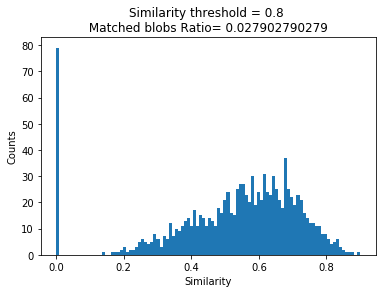

In [488]:
# Statistics
temp_ratio_blob_matched = np.count_nonzero(im_blob_typical[sec])/float(n_blobs[secIndex])
fig_hist_simscore_sec200 = plt.figure();
fig_hist_simscore_sec200 = plt.hist(im_blob_sim_score[200],bins=100);
fig_hist_simscore_sec200 = plt.xlabel('Similarity')
fig_hist_simscore_sec200 = plt.ylabel('Counts')
fig_hist_simscore_sec200 = plt.title('Similarity threshold = %s \n Matched blobs Ratio= %s '% (o_simil_threshold,temp_ratio_blob_matched))

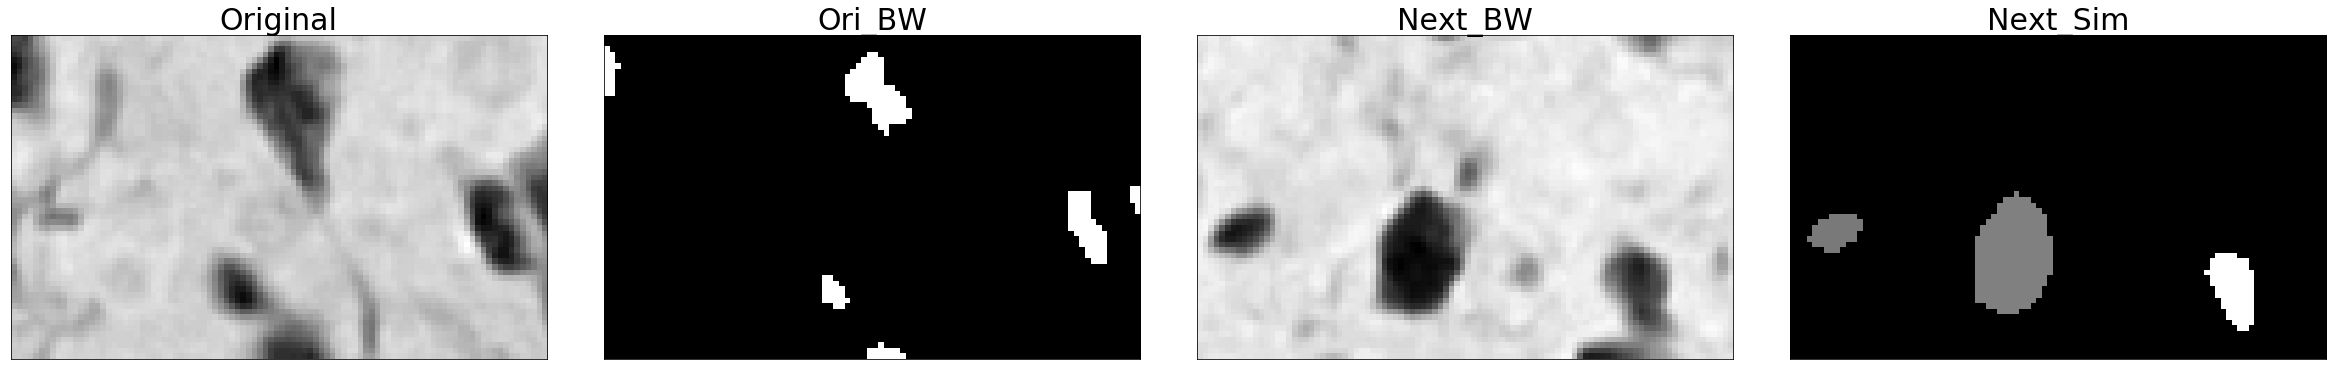

In [489]:
tempBlobIndex = 2
display_images_in_grids([    
        fun_rescale_grayscale_image(fun_crop_images(im_cropped[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),pvmax=1),
    fun_crop_images(im_BW[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),
    fun_crop_images(im_rescale[secIndex+1],*im_blob_crop_range_1D[sec][tempBlobIndex]),
    im_blob_sim_crop_im[sec][tempBlobIndex]
                            ],titles=['Original','Ori_BW','Next_BW','Next_Sim'],
                            nc=4,cmap=plt.cm.gray)

Blob ID 575


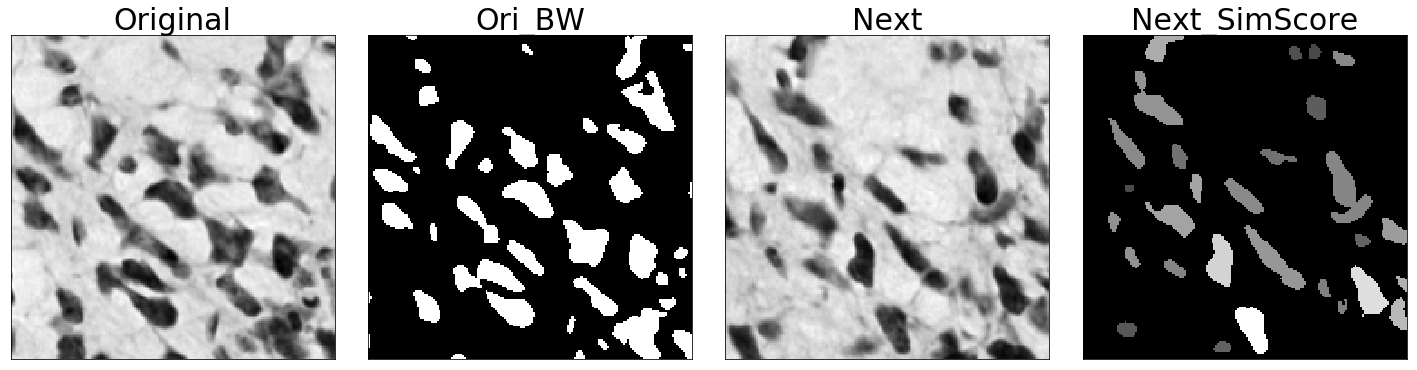

Blob ID 810


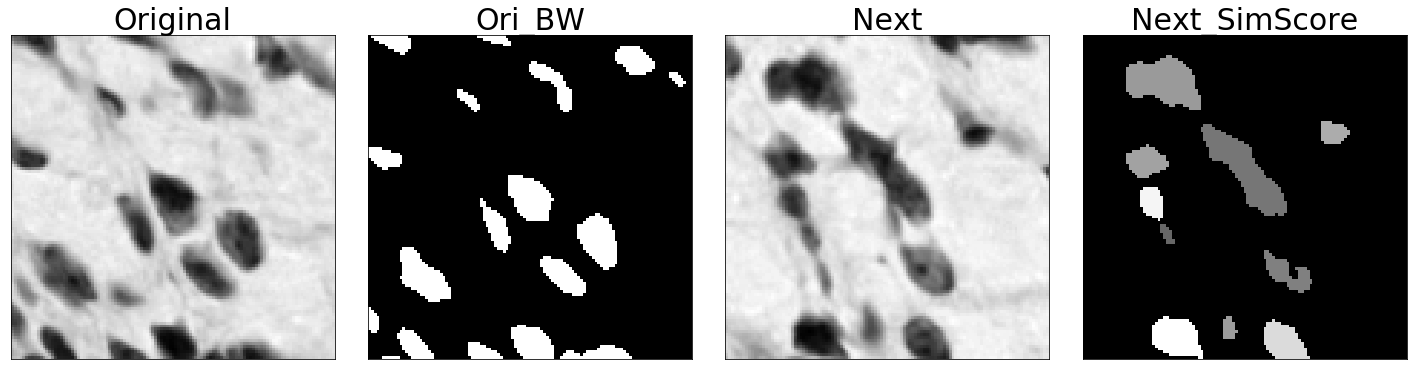

Blob ID 296


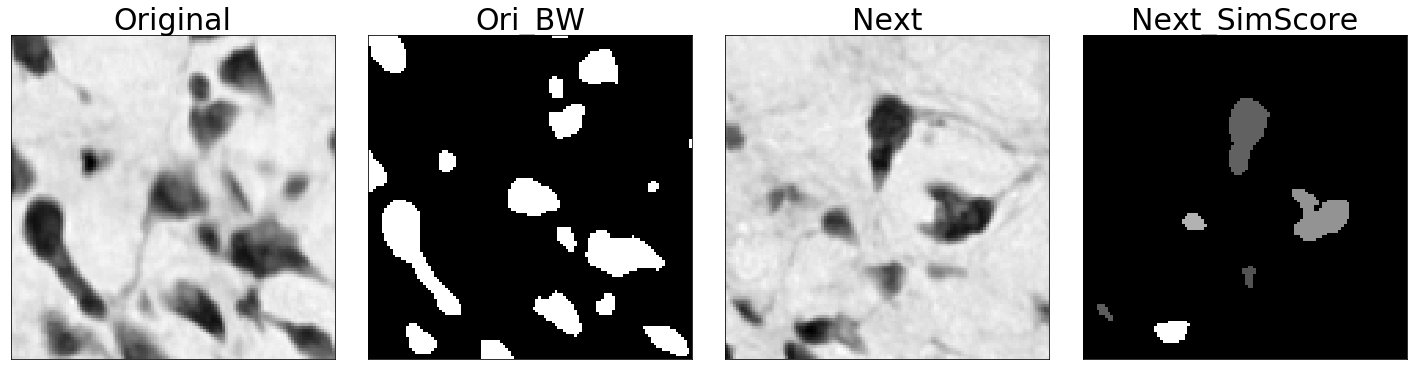

Blob ID 651


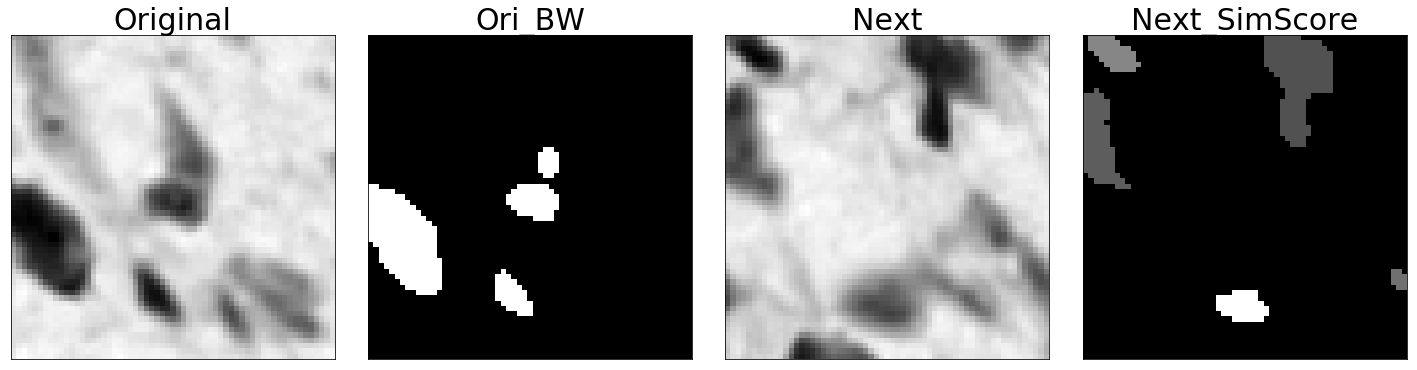

Blob ID 690


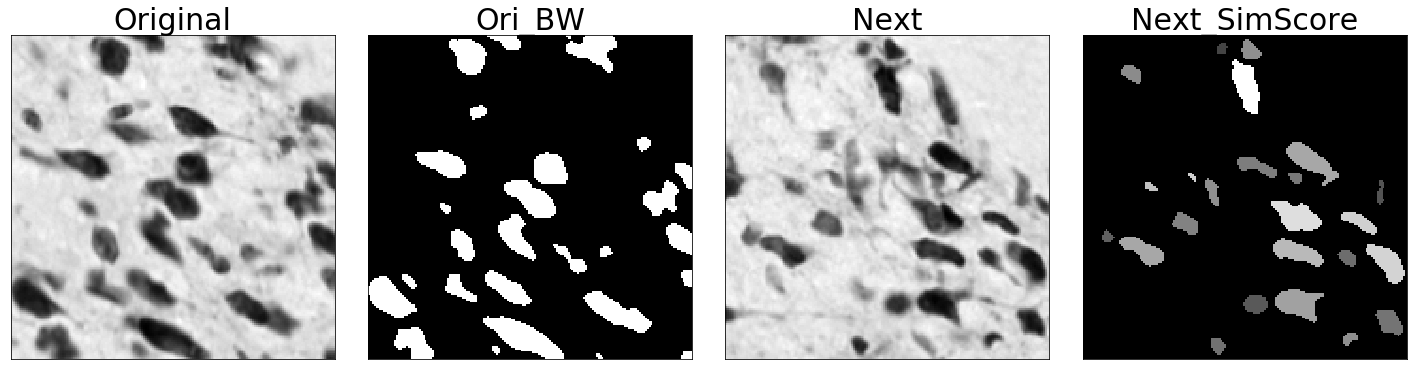

Blob ID 457


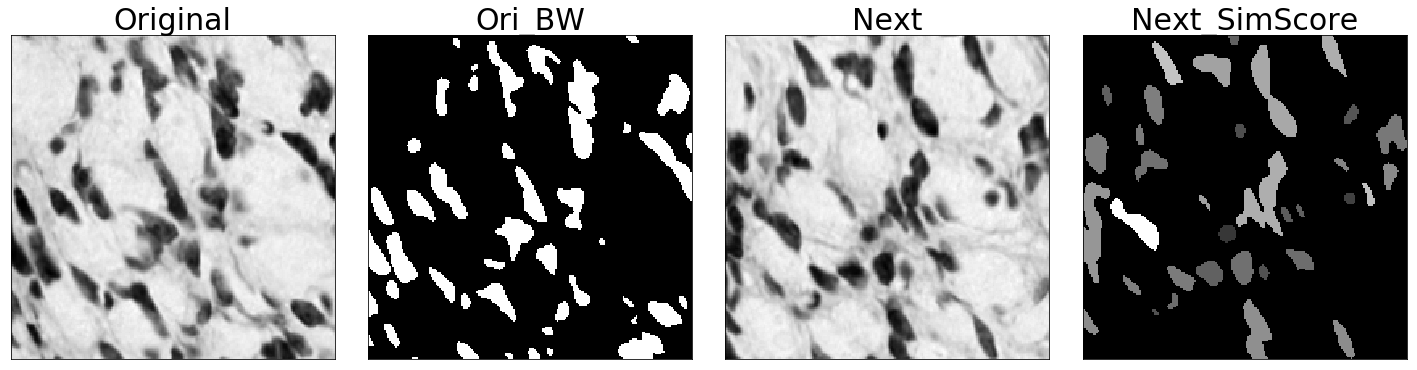

Blob ID 939


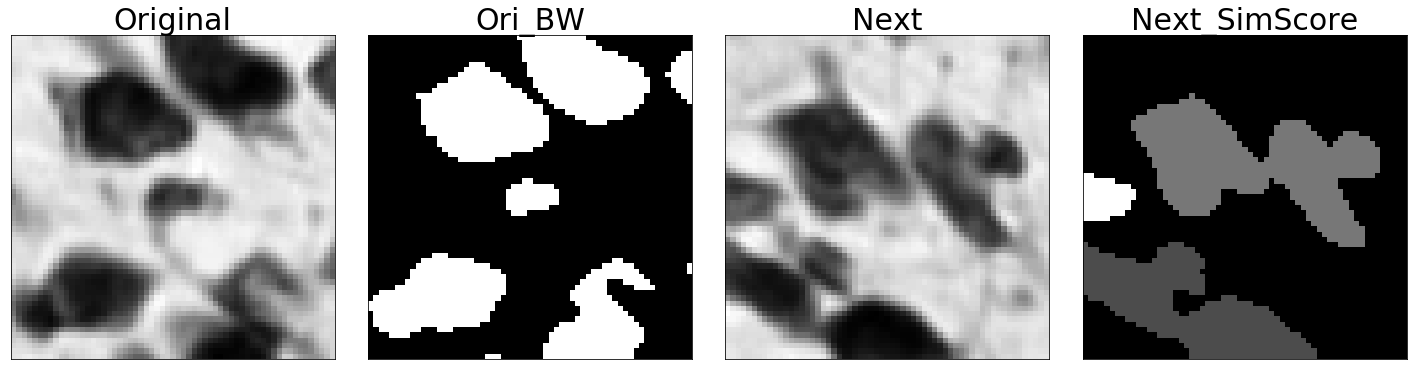

Blob ID 348


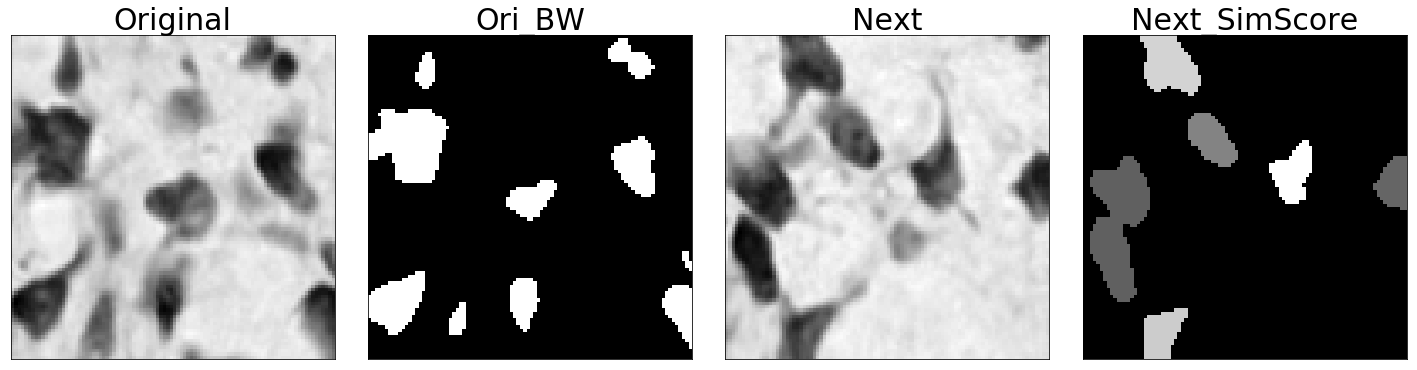

Blob ID 614


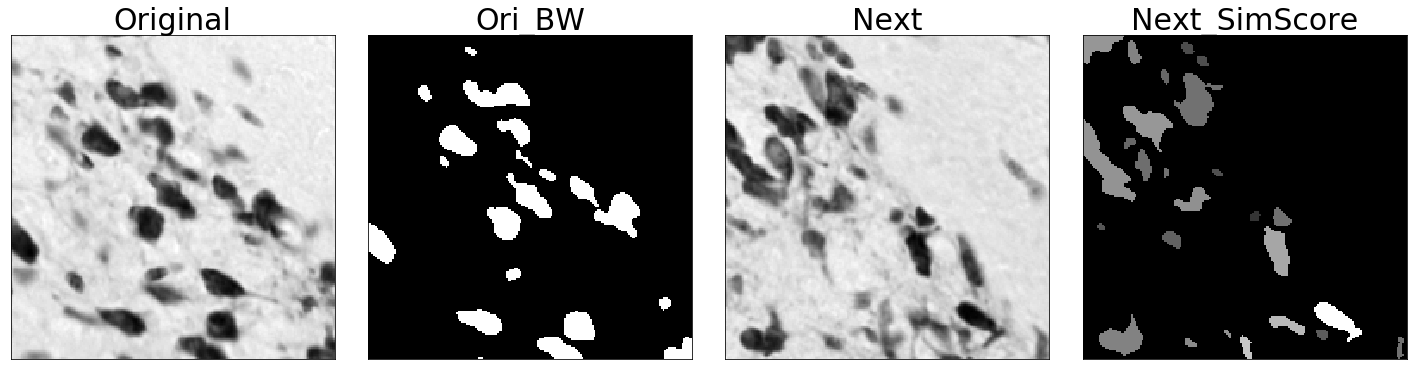

Blob ID 934


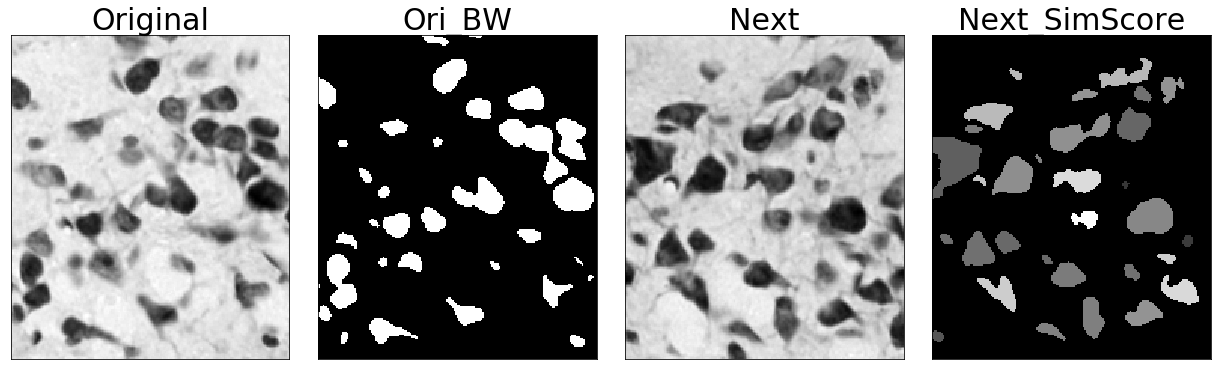

Blob ID 487


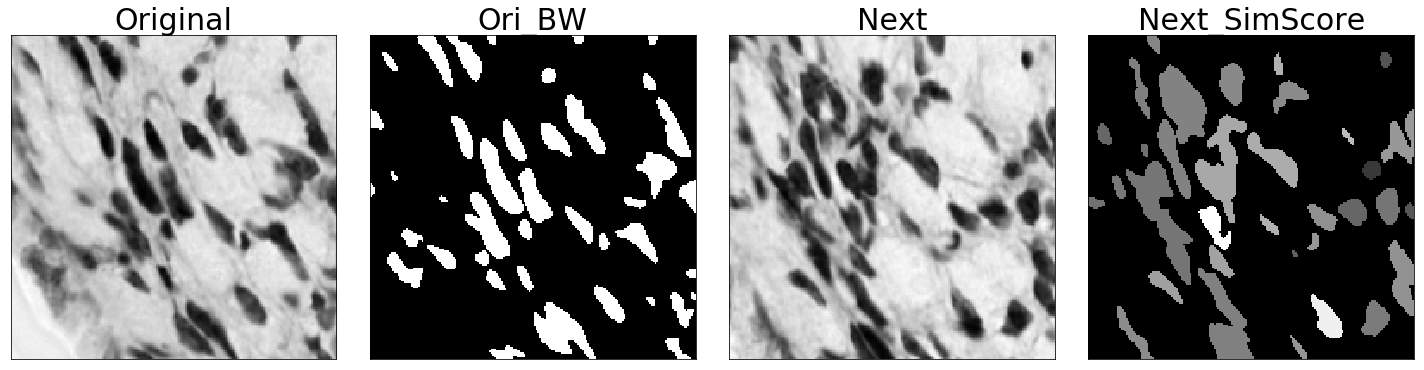

Blob ID 472


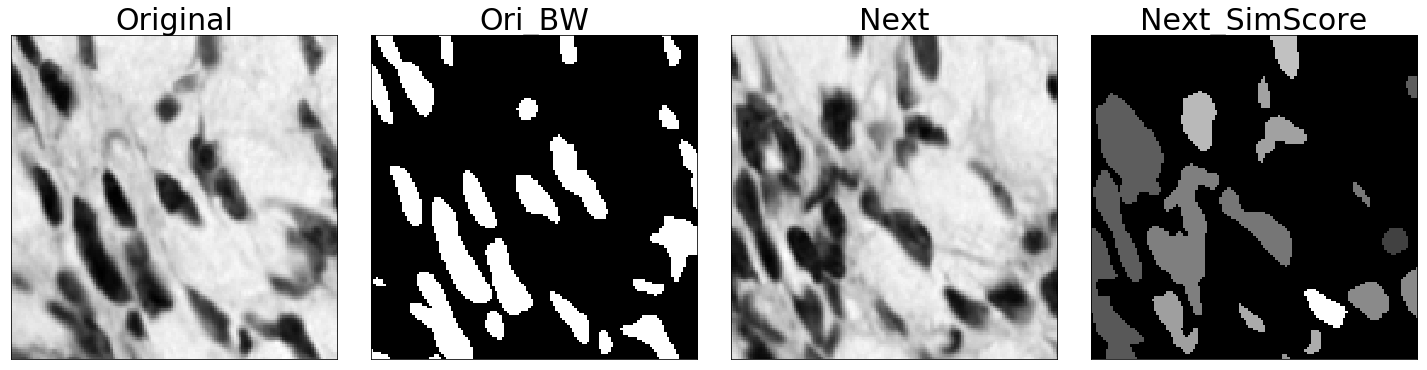

Blob ID 105


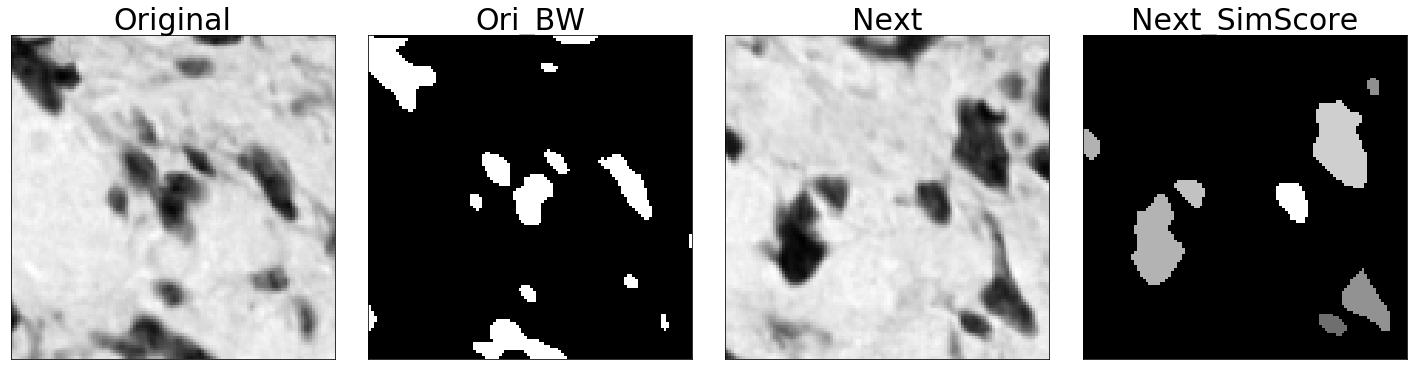

Blob ID 646


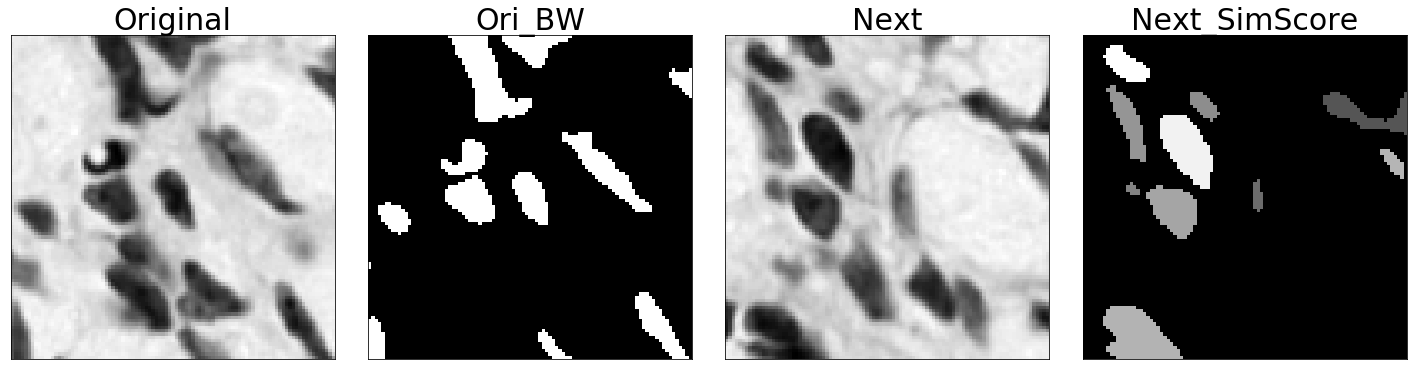

Blob ID 889


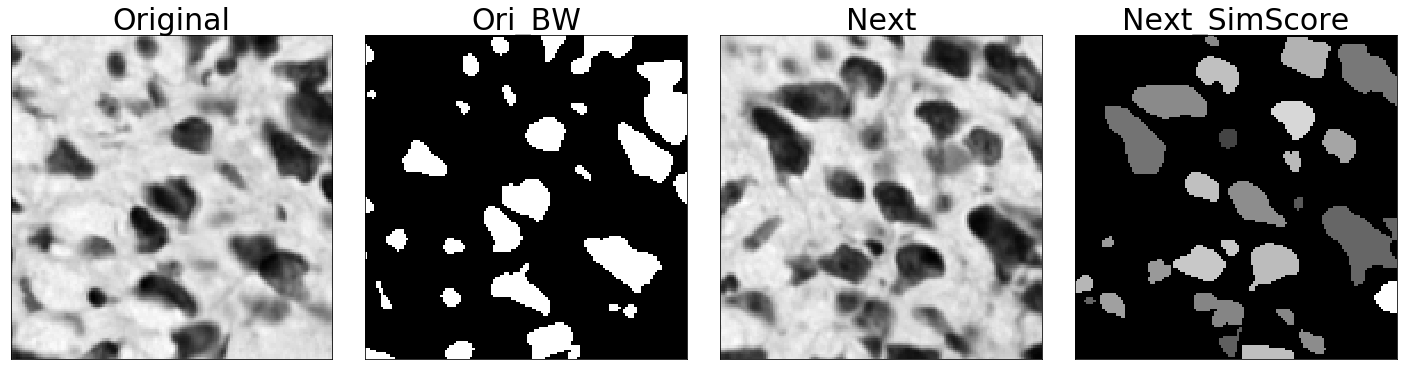

Blob ID 825


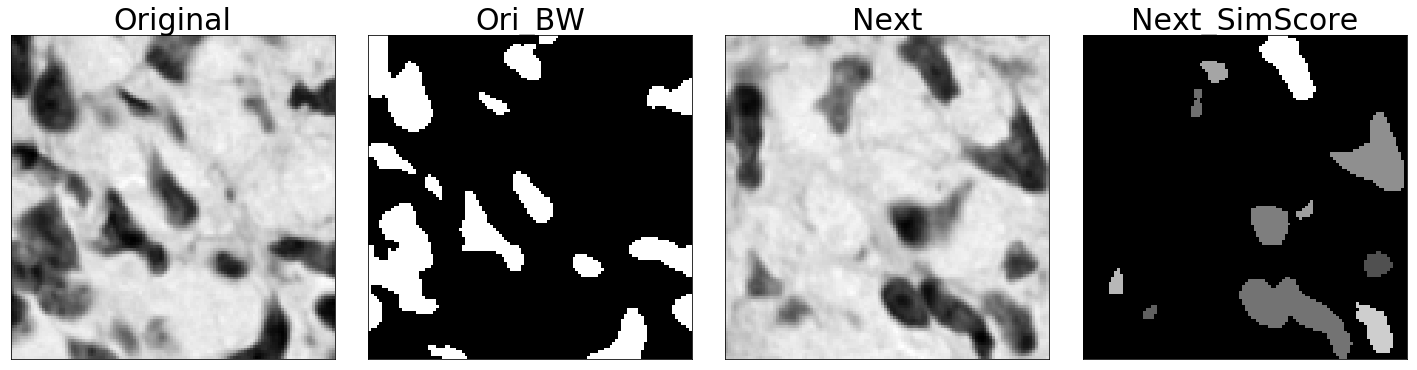

Blob ID 962


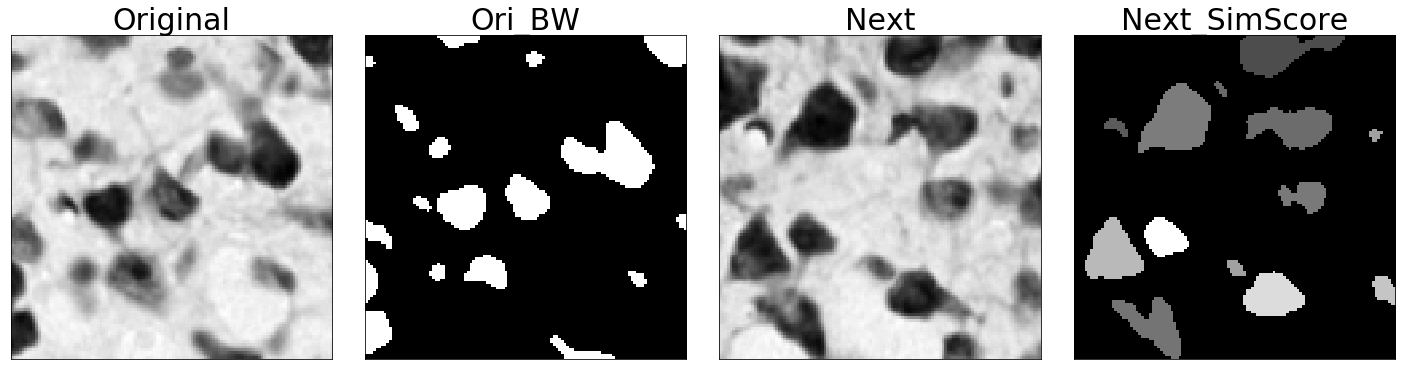

Blob ID 385


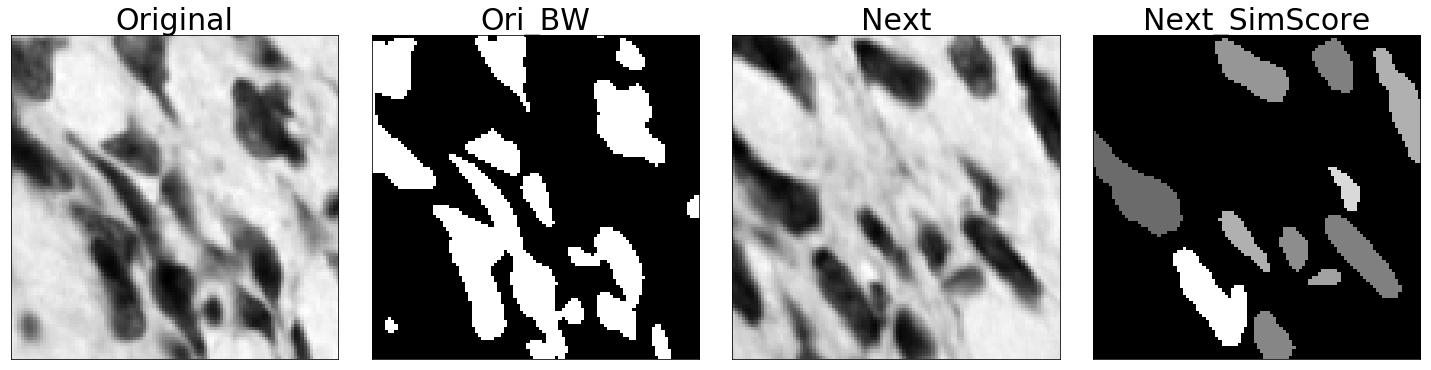

Blob ID 704


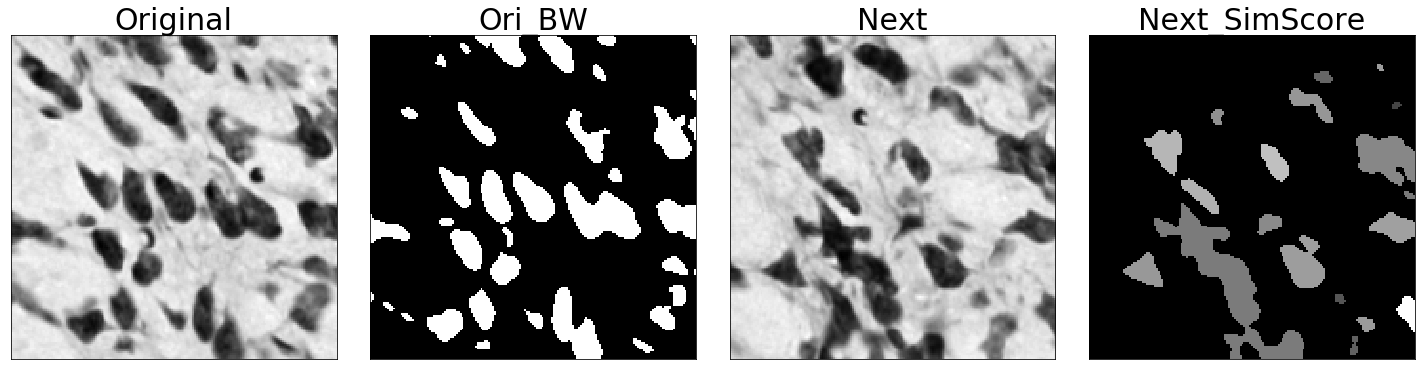

Blob ID 746


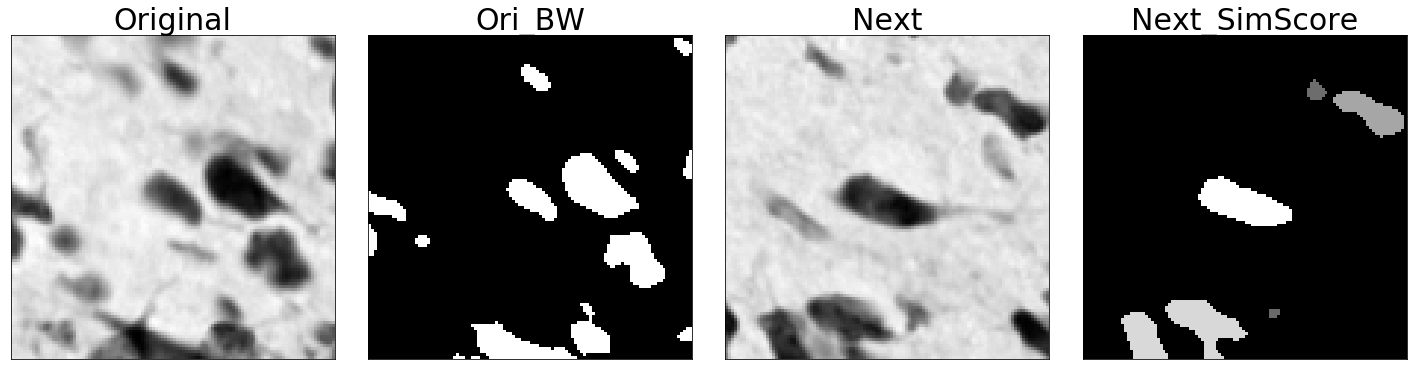

In [492]:
# Check if really similar
option_vis_blob_margion = 30
for tempBlobIndex in np.random.choice(temp_matched_blob_index,20,replace=False):
    print('Blob ID %d'%tempBlobIndex)
    display_images_in_grids([    
        fun_rescale_grayscale_image(fun_crop_images(im_cropped[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),pvmax=1),
    fun_crop_images(im_BW[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),
    fun_rescale_grayscale_image(fun_crop_images(im_cropped[secIndex+1],*im_blob_crop_range_1D[sec][tempBlobIndex])),
    im_blob_sim_crop_im[sec][tempBlobIndex]
    ],titles=['Original','Ori_BW','Next','Next_SimScore'],
                            nc=4,cmap=plt.cm.gray)

# Training Perceptron for 7N 

In [34]:
# Get contour for 7N
contour, _ = DataManager.load_annotation_v3(stack=stack)
contour = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour,stack=stack)
contour

'No object named structures in the file'


Annotation has no structures.


creator downsample  \
10001747656938   yuncong          1   
100179733918340  yuncong          1   
100436364177927  yuncong          1   
100739086246252  yuncong          1   
100789576647628  yuncong          1   
100920121924561  yuncong          1   
101502220498012  yuncong          1   
101511503885989  yuncong          1   
101528011891079  yuncong          1   
101709650119044  yuncong          1   
101766370294917  yuncong          1   
101798332186952  yuncong          1   
101835871596726  yuncong          1   
101860661226065  yuncong          1   
102327450093589  yuncong          1   
102364145529843  yuncong          1   
102894477533672  yuncong          1   
10305105721462   yuncong          1   
103068813277037  yuncong          1   
103164799567817  yuncong          1   
103167177058136  yuncong          1   
103185227814691  yuncong          1   
103227188346909  yuncong          1   
103371609852368  yuncong          1   
103441960876852  yuncong          1   
103456702454204  yuncong          1   
103621508216997  yuncong          1   
103706406166204  yuncong          1   
103732852355920  yuncong          1   
104150322368967  yuncong          1   
...                  ...        ...   
97016267603086   yuncong          1   
97170259116334   yuncong          1   
97346173467704   yuncong          1   
97404696017701   yuncong          1   
97504196731817   yuncong          1   
97619991952827   yuncong          1   
97890985022292   yuncong          1   
9791958451837    yuncong          1   
97971861082886   yuncong          1   
98069629546362   yuncong          1   
98214393752096   yuncong          1   
98330724938210   yuncong          1   
98348450774378   yuncong          1   
98371271576446   yuncong          1   
98407500342633   yuncong          1   
98419828539590   yuncong          1   
98698157497252   yuncong          1   
98700835314001   yuncong          1   
98748026747925   yuncong          1   
9886055009911    yuncong          1   
99140085222196   yuncong          1   
99183589352753   yuncong          1   
99199686302154   yuncong          1   
9928915712736    yuncong          1   
99429586937135   yuncong          1   
99579169895708   yuncong          1   
99657345404738   yuncong          1   
9990699061935    yuncong          1   
99910308596392   yuncong          1   
99960330881585   yuncong          1   

                                                             edits flags  \
10001747656938   [{u'username': u'yuncong', u'timestamp': u'091...     1   
100179733918340  [{u'username': u'yuncong', u'timestamp': u'091...     1   
100436364177927  [{u'username': u'yuncong', u'timestamp': u'091...     1   
100739086246252  [{u'username': u'yuncong', u'timestamp': u'091...     0   
100789576647628  [{u'username': u'yuncong', u'timestamp': u'091...     0   
100920121924561  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101502220498012  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101511503885989  [{u'username': u'yuncong', u'timestamp': u'091...     0   
101528011891079  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101709650119044  [{u'username': u'yuncong', u'timestamp': u'091...     0   
101766370294917  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101798332186952  [{u'username': u'yuncong', u'timestamp': u'091...     0   
101835871596726  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101860661226065  [{u'username': u'yuncong', u'timestamp': u'091...     0   
102327450093589  [{u'username': u'yuncong', u'timestamp': u'091...     1   
102364145529843  [{u'username': u'yuncong', u'timestamp': u'091...     1   
102894477533672  [{u'username': u'yuncong', u'timestamp': u'091...     1   
10305105721462   [{u'username': u'yuncong', u'timestamp': u'091...     1   
103068813277037  [{u'username': u'yuncong', u'timestamp': u'091...     1   
103164799567817  [{u'username': u'yuncong', u'timestamp': u'091...     0   
10

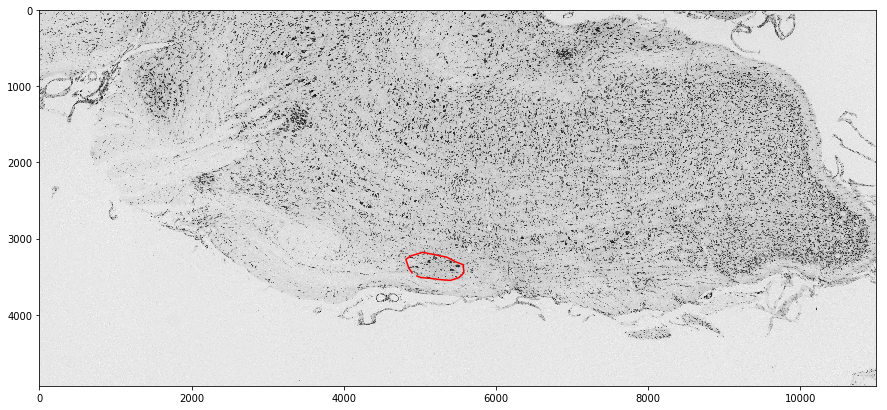

In [45]:
# Get the contour for 7N
structure_name = '7N'
vertices_dic_7N = {cnt['section']:np.array(cnt['vertices']) for _, cnt in contour[contour['name'] == structure_name].iterrows()}
sectionList_7N = vertices_dic_7N.keys()
# Show the contour for 7N
plt.figure(figsize=(15,15))
plt.imshow(im_rescale[sec],cmap=plt.cm.gray)
plt.plot(vertices_dic_7N[sec][:,0] - crop_1_min, vertices_dic_7N[sec][:,1] - crop_0_min,  '-r')

In [88]:
# Get blobs in 7N
curr_sec_blob_centroid = [im_blob_prop[sec][tempBID]['centroid'] for tempBID in range(n_blobs[sec])]
curr_sec_blob_insideQ  = fun_blobs_in_polygen(curr_sec_blob_centroid, vertices_dic_7N[sec], crop_min_list=[crop_0_min,crop_1_min])
curr_sec_blob_inside_props = np.array(im_blob_prop[sec])[curr_sec_blob_insideQ]
curr_sec_blob_inside_labels = [curr_sec_blob_inside_props[temp]['label'] for temp in range(len(curr_sec_blob_inside_props))]

In [ ]:
# Get blobs 

In [56]:
temp_next_sec_blob_centroid = 
# Get blobs outside the labeled region
temp_PosSam_Polygon = Polygon(vertices_dic_7N[sec][:,[1,0]])
temp_surround = temp_PosSam_Polygon.buffer(margin,resolution=2)
tempPath_surr = matplotlib.path.Path(list(temp_surround.exterior.coords))
tempBlobInside_surr = tempPath_surr.contains_points(temp_curr_sec_blob_centroid)

tempBlobOutIndex = tempBlobIndex[np.logical_not(tempBlobInside_surr)]

# tempBlobInside_surr = np.logical_xor(tempBlobInside,tempBlobInside_surr)
# tempBlobSurrIndex = tempBlobIndex[tempBlobInside_surr]
# temp_curr_BlobsProps_in_structure_surr = np.array(im_blob_prop[sec])[tempBlobInside_surr]
# temp_curr_BlobsNum_in_structure_surr = len(temp_curr_BlobsProps_in_structure_surr)

In [58]:
np.logical_not(tempBlobInside_surr)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)